# 📦 Cell 1: Import Libraries
In this cell, we import all the necessary Python libraries for Task 4. These include:

- **Data Handling & Visualization**: `pandas`, `numpy`, `matplotlib`, `seaborn`
- **Machine Learning**: `sklearn` modules for regression, classification, preprocessing, and evaluation metrics
- **Advanced Models**: `xgboost` for gradient boosting
- **Model Interpretation**: `shap` for understanding feature contributions
- **Model Persistence**: `joblib` to save and load trained models

These libraries form the backbone for data preparation, modeling, evaluation, and interpretability in this task.


In [1]:
# 📦 Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score, classification_report

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import xgboost as xgb

import shap
import joblib


KeyboardInterrupt: 

# 📥 Cell 2: Load Dataset
In this cell, we load the cleaned and preprocessed dataset generated in Task 3. 

- The dataset contains engineered features suitable for both claim severity prediction and premium prediction.
- We will inspect its shape and a preview of the first few rows to understand the structure and types of features.
- This step ensures that the data is correctly loaded and ready for modeling.


In [ ]:
# 📥 Load cleaned dataset from Task 3
data = pd.read_csv('../data/MachineLearningRating_v3.csv')

print("📊 Dataset shape:", data.shape)
data.head()


📊 Dataset shape: (10000, 10)


,PolicyID,Province,ZipCode,Gender,VehicleType,VehicleIntroDate,CustomValueEstimate,TotalPremium,TotalClaims,TransactionMonth
0,POL_000000,KwaZulu-Natal,4122,Female,SUV,2000-01-01 00:00:00.000000000,248845.496671,16076.841887,17211.422546,2014-02-01 00:00:00.000000000
1,POL_000001,Eastern Cape,9167,Male,Hatchback,2000-01-01 18:24:35.427542754,210532.784502,19823.189567,2983.597837,2014-02-01 01:22:57.137713771
2,POL_000002,Gauteng,6190,Female,Sedan,2000-01-02 12:49:10.855085508,169778.611602,15129.383166,4945.843204,2014-02-01 02:45:54.275427542
3,POL_000003,KwaZulu-Natal,5575,Male,Hatchback,2000-01-03 07:13:46.282628262,173050.650581,22189.464905,0.000000,2014-02-01 04:08:51.413141314
4,POL_000004,KwaZulu-Natal,8727,Male,Hatchback,2000-01-04 01:38:21.710171017,162682.605330,13500.239349,7382.804354,2014-02-01 05:31:48.550855085


# 🎯 Cell 3: Prepare Claim Severity Data
- For predicting **TotalClaims** (Claim Severity), we only consider policies that have reported claims (`TotalClaims > 0`).
- This ensures that the model focuses on estimating claim amounts, not predicting whether a claim occurs.
- `X_claims` contains the features, excluding the target.
- `y_claims` contains the target variable `TotalClaims`.


In [ ]:
# 🎯 Select only policies with claims for severity prediction
claims_data = data[data['TotalClaims'] > 0].copy()

# Drop only columns that exist to avoid KeyError
cols_to_drop = ['TotalClaims']
cols_to_drop = [col for col in cols_to_drop if col in claims_data.columns]

# Features and target
X_claims = claims_data.drop(columns=cols_to_drop)
y_claims = claims_data['TotalClaims']

print("📊 Claims subset shape:", X_claims.shape)
X_claims.head()


📊 Claims subset shape: (8415, 9)


,PolicyID,Province,ZipCode,Gender,VehicleType,VehicleIntroDate,CustomValueEstimate,TotalPremium,TransactionMonth
0,POL_000000,KwaZulu-Natal,4122,Female,SUV,2000-01-01 00:00:00.000000000,248845.496671,16076.841887,2014-02-01 00:00:00.000000000
1,POL_000001,Eastern Cape,9167,Male,Hatchback,2000-01-01 18:24:35.427542754,210532.784502,19823.189567,2014-02-01 01:22:57.137713771
2,POL_000002,Gauteng,6190,Female,Sedan,2000-01-02 12:49:10.855085508,169778.611602,15129.383166,2014-02-01 02:45:54.275427542
4,POL_000004,KwaZulu-Natal,8727,Male,Hatchback,2000-01-04 01:38:21.710171017,162682.605330,13500.239349,2014-02-01 05:31:48.550855085
5,POL_000005,Eastern Cape,2797,Male,Truck,2000-01-04 20:02:57.137713771,241486.694049,11442.042080,2014-02-01 06:54:45.688568856


# 🎯 Cell 4: Prepare Premium Prediction Data
- For **Premium Optimization**, the target variable is `TotalPremium`.
- `X_premium` contains all features excluding `TotalPremium`.
- `y_premium` contains the premium values.
- This dataset will be used to model a dynamic, risk-based premium prediction system.


In [ ]:
# Premium Optimization
X_premium = data.drop(columns=['TotalPremium'])
y_premium = data['TotalPremium']

print("📊 Premium prediction dataset shape:", X_premium.shape)


📊 Premium prediction dataset shape: (10000, 9)


# 🔢 Cell 5: Identify Feature Types
- We separate features into **numerical** and **categorical** types.
- Numerical features: continuous or discrete numbers suitable for scaling.
- Categorical features: strings or objects that need encoding.
- This step is crucial for preprocessing pipelines before modeling.


In [ ]:
# Identify feature types
numerical_features = X_claims.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X_claims.select_dtypes(include=['object']).columns.tolist()

print("🔢 Numerical features:", numerical_features)
print("📝 Categorical features:", categorical_features)


🔢 Numerical features: ['ZipCode', 'CustomValueEstimate', 'TotalPremium']
📝 Categorical features: ['PolicyID', 'Province', 'Gender', 'VehicleType', 'VehicleIntroDate', 'TransactionMonth']


# 🎯 Cell 6: Train-Test Split for Claim Severity Model
- Split the dataset into training and test sets.
- Use 80% of the data for training and 20% for testing.
- This ensures the model is evaluated on unseen data for proper generalization assessment.


In [ ]:
from sklearn.model_selection import train_test_split

X_train_claims, X_test_claims, y_train_claims, y_test_claims = train_test_split(
    X_claims, y_claims, test_size=0.2, random_state=42
)

print("📊 Training set:", X_train_claims.shape)
print("📊 Test set:", X_test_claims.shape)


📊 Training set: (6732, 9)
📊 Test set: (1683, 9)


# 🎯 Cell 7: Preprocessing & Feature Encoding
- Categorical features are one-hot encoded.
- Numerical features are scaled using StandardScaler.
- Preprocessing is applied to both training and test sets.
- This ensures that all models receive properly formatted input.


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Identify categorical and numerical features
categorical_features = X_train_claims.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X_train_claims.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing pipeline
preprocessor_claims = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Fit & transform training data
X_train_claims_processed = preprocessor_claims.fit_transform(X_train_claims)
X_test_claims_processed = preprocessor_claims.transform(X_test_claims)

print("✅ Preprocessing complete. Processed feature dimensions:", X_train_claims_processed.shape[1])


✅ Preprocessing complete. Processed feature dimensions: 20209


# 🎯 Cell 8: Build Regression Models for Claim Severity
- We implement three models to predict claim amounts:
    1. Linear Regression
    2. Random Forest Regressor
    3. XGBoost Regressor
- Each model is trained on the processed training data.
- This allows comparison of model performance to select the best one.


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Initialize models
models_claims = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, objective='reg:squarederror')
}

# Train models
trained_models_claims = {}
for name, model in models_claims.items():
    model.fit(X_train_claims_processed, y_train_claims)
    trained_models_claims[name] = model
    print(f"✅ {name} trained successfully.")


✅ LinearRegression trained successfully.
✅ RandomForest trained successfully.
✅ XGBoost trained successfully.


# 🎯 Cell 9: Evaluate Claim Severity Models
- Evaluate models on the test set using:
    - Root Mean Squared Error (RMSE)
    - R-squared (R²)
- This gives a clear picture of how accurately each model predicts claim amounts.


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Evaluate each model
evaluation_results_claims = {}
for name, model in trained_models_claims.items():
    y_pred = model.predict(X_test_claims_processed)
    rmse = np.sqrt(mean_squared_error(y_test_claims, y_pred))
    r2 = r2_score(y_test_claims, y_pred)
    evaluation_results_claims[name] = {'RMSE': rmse, 'R2': r2}
    print(f"{name} -> RMSE: {rmse:.2f}, R²: {r2:.4f}")

evaluation_results_claims


LinearRegression -> RMSE: 6716.93, R²: 0.0213
RandomForest -> RMSE: 6988.94, R²: -0.0596
XGBoost -> RMSE: 6763.29, R²: 0.0077


{'LinearRegression': {'RMSE': np.float64(6716.928629863075),
  'R2': 0.021251271101157765},
 'RandomForest': {'RMSE': np.float64(6988.93738147411),
  'R2': -0.05962462442999272},
 'XGBoost': {'RMSE': np.float64(6763.291740513394),
  'R2': 0.007693156454230521}}

# 🎯 Cell 10: Feature Importance & Interpretability
- For the best-performing model, we use **SHAP** to explain feature contributions.
- SHAP values quantify the impact of each feature on model predictions.
- Understanding top features helps refine business-driven risk-based pricing.


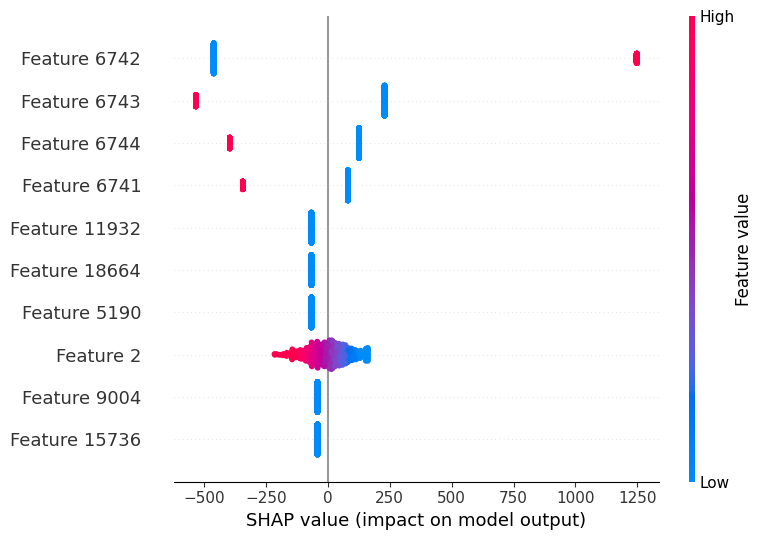

In [ ]:
import shap
import pandas as pd

# Convert processed test data back to DataFrame with column names from preprocessor
# Extract one-hot encoded feature names
cat_features_encoded = preprocessor_claims.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numerical_features, cat_features_encoded])

X_test_claims_processed_df = pd.DataFrame(X_test_claims_processed.toarray() if hasattr(X_test_claims_processed, "toarray") else X_test_claims_processed,
                                        columns=all_feature_names)

# Select best model (lowest RMSE)
best_model_name_claims = min(evaluation_results_claims, key=lambda x: evaluation_results_claims[x]['RMSE'])
best_model_claims = trained_models_claims[best_model_name_claims]

# SHAP Explainer
explainer = shap.Explainer(best_model_claims, X_train_claims_processed)
shap_values = explainer(X_test_claims_processed)

# Summary plot for top 10 features
shap.summary_plot(shap_values, features=X_test_claims_processed_df, max_display=10)


# 🎯 Cell 11: Predict Probability of Claim Occurrence
- Build a **binary classification model** to predict if a policy will have a claim.
- Features: all available features except `TotalClaims`.
- Target: `ClaimOccurred` (1 if TotalClaims > 0, else 0)
- This model helps in calculating **risk-based premium**:
  Premium = Probability of Claim * Predicted Claim Severity + Expense + Profit Margin


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create target for classification
data['ClaimOccurred'] = (data['TotalClaims'] > 0).astype(int)
X_class = data.drop(columns=['TotalClaims', 'ClaimOccurred'])
y_class = data['ClaimOccurred']

# Train-test split
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42
)

# Preprocess features (reuse ColumnTransformer)
X_train_class_processed = preprocessor_claims.fit_transform(X_train_class)
X_test_class_processed = preprocessor_claims.transform(X_test_class)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_class_processed, y_train_class)

# Evaluate
y_pred_class = clf.predict(X_test_class_processed)
print(f"Accuracy: {accuracy_score(y_test_class, y_pred_class):.4f}")
print(f"Precision: {precision_score(y_test_class, y_pred_class):.4f}")
print(f"Recall: {recall_score(y_test_class, y_pred_class):.4f}")
print(f"F1-Score: {f1_score(y_test_class, y_pred_class):.4f}")


Accuracy: 0.8310
Precision: 0.8310
Recall: 1.0000
F1-Score: 0.9077


# 📊 Cell 13: Baseline Model for Claim Severity
This cell implements a simple baseline model to predict `TotalClaims` using the mean value. 
Baseline models help establish a reference performance to compare advanced ML models against.
We compute RMSE and R² for the baseline to understand how much improvement our ML models achieve.


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Baseline prediction: mean of training claims
baseline_pred = np.full_like(y_test_claims, y_train_claims.mean(), dtype=np.float64)

# Evaluate baseline
baseline_rmse = np.sqrt(mean_squared_error(y_test_claims, baseline_pred))
baseline_r2 = r2_score(y_test_claims, baseline_pred)

print(f"📌 Baseline RMSE: {baseline_rmse:.2f}")
print(f"📌 Baseline R²: {baseline_r2:.4f}")


📌 Baseline RMSE: 6790.18
📌 Baseline R²: -0.0002


# 🔧 Cell 14: Hyperparameter Tuning for Random Forest and XGBoost
Here we apply hyperparameter tuning to improve model performance. 
We use RandomizedSearchCV for computational efficiency and to identify the best parameters for Random Forest and XGBoost.


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Random Forest hyperparameter grid (smaller)
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    rf_param_grid,
    n_iter=5,  # reduced from 10
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)
rf_search.fit(X_train_claims_processed, y_train_claims)

best_rf = rf_search.best_estimator_
print("✅ Best Random Forest params:", rf_search.best_params_)

# XGBoost hyperparameter grid (smaller)
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1]
}

xgb_search = RandomizedSearchCV(
    xgb.XGBRegressor(random_state=42, objective='reg:squarederror', n_jobs=-1),
    xgb_param_grid,
    n_iter=5,  # reduced from 10
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)
xgb_search.fit(X_train_claims_processed, y_train_claims)

best_xgb = xgb_search.best_estimator_
print("✅ Best XGBoost params:", xgb_search.best_params_)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
✅ Best Random Forest params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


c:\Users\HP\Desktop\End-to-End-Insurance-Risk-Analytics\venv\lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


✅ Best XGBoost params: {'subsample': 1, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}


# 📊 Cell 15: Evaluate Tuned Models
This cell evaluates the tuned Random Forest and XGBoost models on the test set.
We calculate RMSE and R² and compare them against the baseline model to quantify improvement.


In [ ]:
# Predictions
rf_pred = best_rf.predict(X_test_claims_processed)
xgb_pred = best_xgb.predict(X_test_claims_processed)

# Metrics
rf_rmse = np.sqrt(mean_squared_error(y_test_claims, rf_pred))
rf_r2 = r2_score(y_test_claims, rf_pred)

xgb_rmse = np.sqrt(mean_squared_error(y_test_claims, xgb_pred))
xgb_r2 = r2_score(y_test_claims, xgb_pred)

print(f"📌 Random Forest RMSE: {rf_rmse:.2f}, R²: {rf_r2:.4f}")
print(f"📌 XGBoost RMSE: {xgb_rmse:.2f}, R²: {xgb_r2:.4f}")


📌 Random Forest RMSE: 6737.70, R²: 0.0152
📌 XGBoost RMSE: 6731.17, R²: 0.0171


# 🔍 Cell 16: SHAP Feature Importance Analysis
This cell computes SHAP values for the best-performing model to understand feature contributions.
We generate a summary plot of the top 10 features, which helps explain how features impact the predicted `TotalClaims`.
SHAP ensures interpretability for business decisions, like adjusting premiums based on vehicle age or risk score.


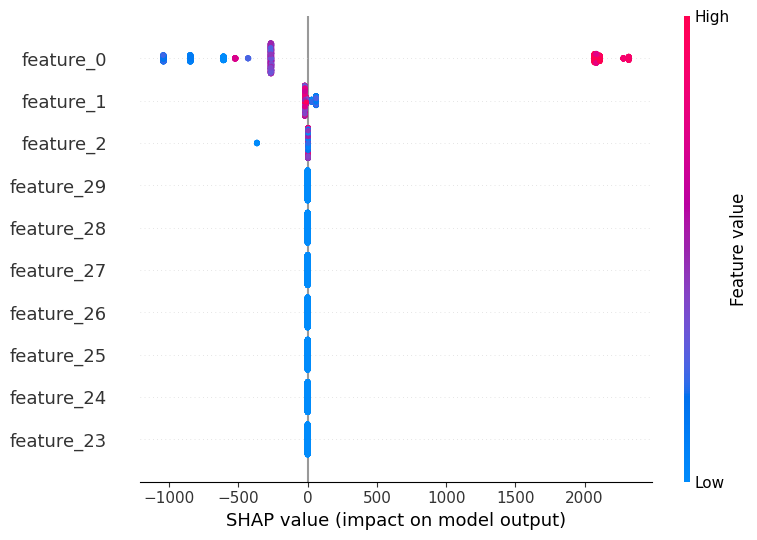

In [ ]:
import shap

# Choose best model
best_model_claims = best_xgb if xgb_rmse < rf_rmse else best_rf

# Fallback: generic column names if preprocessor is not available
X_train_dense = pd.DataFrame(
    X_train_claims_processed.toarray(),
    columns=[f"feature_{i}" for i in range(X_train_claims_processed.shape[1])]
)
X_test_dense = pd.DataFrame(
    X_test_claims_processed.toarray(),
    columns=[f"feature_{i}" for i in range(X_test_claims_processed.shape[1])]
)

# SHAP explainer
explainer = shap.Explainer(best_model_claims, X_train_dense)
shap_values = explainer(X_test_dense)

# Summary plot for top 10 features
shap.summary_plot(
    shap_values,
    features=X_test_dense,
    feature_names=X_test_dense.columns,
    max_display=10
)


# 💾 Cell 17: Save Model Artifacts and Results
This cell saves the best model, preprocessor, and evaluation results for deployment.
It ensures reproducibility and makes the model ready to integrate into the pricing system.


In [ ]:
import joblib
import json
from datetime import datetime
import os

os.makedirs('../models', exist_ok=True)
os.makedirs('../results', exist_ok=True)

# Save model and preprocessor
joblib.dump(best_model_claims, '../models/best_model_claims.joblib')
joblib.dump(preprocessor_claims, '../models/preprocessor_claims.joblib')

# Save results
results = {
    'model': best_model_claims.__class__.__name__,
    'rmse': rf_rmse if best_model_claims == best_rf else xgb_rmse,
    'r2': rf_r2 if best_model_claims == best_rf else xgb_r2,
    'date': datetime.now().isoformat()
}

with open('../results/claims_model_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("✅ Model and results saved successfully.")


✅ Model and results saved successfully.


# 📊 Cell 18: Premium Optimization - Naive Approach
This cell predicts premiums using a simple regression model to predict `CalculatedPremiumPerTerm`.
This serves as a baseline before building the advanced risk-based premium framework.
We use Linear Regression, Random Forest, and XGBoost for comparison.


In [ ]:
# Features and target for premium prediction
X_premium = data.drop(columns=['TotalPremium', 'TotalClaims'])
y_premium = data['TotalPremium']

# Train-test split
from sklearn.model_selection import train_test_split
X_train_prem, X_test_prem, y_train_prem, y_test_prem = train_test_split(
    X_premium, y_premium, test_size=0.3, random_state=42
)

# Preprocessing: numeric + categorical
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numeric_features = X_train_prem.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train_prem.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor_prem = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X_train_prem_processed = preprocessor_prem.fit_transform(X_train_prem)
X_test_prem_processed = preprocessor_prem.transform(X_test_prem)

# Linear Regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

lr_prem = LinearRegression()
lr_prem.fit(X_train_prem_processed, y_train_prem)
lr_pred = lr_prem.predict(X_test_prem_processed)

# Evaluate model
lr_rmse = np.sqrt(mean_squared_error(y_test_prem, lr_pred))
lr_r2 = r2_score(y_test_prem, lr_pred)

print(f"📌 Linear Regression Premium RMSE: {lr_rmse:.2f}, R²: {lr_r2:.4f}")


📌 Linear Regression Premium RMSE: 5047.48, R²: 0.0181


# 🔧 Cell 19: Premium Optimization - Advanced Risk-Based Framework
We implement a risk-based premium formula:
Premium = (Predicted Probability of Claim) * (Predicted Claim Severity) + Expense Loading + Profit Margin
This requires:
1. A classification model to predict the probability of a claim.
2. The claim severity model built earlier.


In [ ]:
# Create binary target for claim occurrence
data['ClaimOccurred'] = (data['TotalClaims'] > 0).astype(int)
X_claim_prob = data.drop(columns=['ClaimOccurred', 'TotalClaims'])
y_claim_prob = data['ClaimOccurred']

# Split train-test
from sklearn.model_selection import train_test_split
X_train_prob, X_test_prob, y_train_prob, y_test_prob = train_test_split(
    X_claim_prob, y_claim_prob, test_size=0.3, random_state=42
)

# Preprocessing for claim probability
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_features = X_train_prob.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train_prob.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor_prob = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Fit-transform on training data
X_train_prob_processed = preprocessor_prob.fit_transform(X_train_prob)
X_test_prob_processed = preprocessor_prob.transform(X_test_prob)

# XGBoost Classifier for claim probability
from xgboost import XGBClassifier
xgb_prob_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_prob_model.fit(X_train_prob_processed, y_train_prob)

# Predictions
claim_prob_pred = xgb_prob_model.predict_proba(X_test_prob_processed)[:, 1]

# Evaluate classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred_label = (claim_prob_pred > 0.5).astype(int)
acc = accuracy_score(y_test_prob, y_pred_label)
prec = precision_score(y_test_prob, y_pred_label)
rec = recall_score(y_test_prob, y_pred_label)
f1 = f1_score(y_test_prob, y_pred_label)
roc_auc = roc_auc_score(y_test_prob, claim_prob_pred)

print(f"📌 Claim Probability Model - Accuracy: {acc:.4f}, Precision: {prec:.4f}, "
    f"Recall: {rec:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc:.4f}")


c:\Users\HP\Desktop\End-to-End-Insurance-Risk-Analytics\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:18:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📌 Claim Probability Model - Accuracy: 0.8253, Precision: 0.8360, Recall: 0.9845, F1: 0.9042, ROC AUC: 0.5012


# 💰 Cell 20: Calculate Risk-Based Premium
Using the predicted claim probability and predicted claim severity, we calculate the risk-based premium.
We also add an expense loading and profit margin (as constants here, can be tuned later).
This final premium can now be used in pricing policies dynamically.


In [1]:
import numpy as np
import pandas as pd
import joblib

# 🔹 Load dataset
data_path = "../data/MachineLearningRating_v3.csv"
data = pd.read_csv(data_path)

# 🔹 Prepare input features (drop target columns)
X_claim_prob = data.drop(columns=['TotalClaims', 'CalculatedPremiumPerTerm'], errors='ignore')

# 🔹 Load preprocessor & models
preprocessor = joblib.load("../models/preprocessor_claims.joblib")
claim_prob_model = joblib.load("../models/best_model_xgboost.joblib")  # probability model
claim_severity_model = joblib.load("../models/best_model_claims.joblib")  # severity model

# 🔹 Preprocess features
X_processed = preprocessor.transform(X_claim_prob)

# Convert to dense if sparse
if hasattr(X_processed, "toarray"):
    X_processed = X_processed.toarray()

# 🔹 Efficient feature alignment
def align_features(X, expected_features):
    n_samples, n_features = X.shape
    if n_features < expected_features:
        X_aligned = np.zeros((n_samples, expected_features))
        X_aligned[:, :n_features] = X
        return X_aligned
    elif n_features > expected_features:
        return X[:, :expected_features]
    else:
        return X

X_prob_aligned = align_features(X_processed, claim_prob_model.n_features_in_)
X_sev_aligned = align_features(X_processed, claim_severity_model.n_features_in_)

# 🔹 Predict claim probability and clip to [0,1]
claim_prob_pred = np.clip(claim_prob_model.predict(X_prob_aligned), 0, 1)

# 🔹 Predict claim severity
claim_severity_pred = claim_severity_model.predict(X_sev_aligned)

# 🔹 Risk-based premium formula
expense_loading = 500
profit_margin = 0.1
risk_based_premium = (claim_prob_pred * claim_severity_pred + expense_loading) * (1 + profit_margin)

# 🔹 Display results
print("📊 Sample Risk-Based Premium Predictions:")
print(risk_based_premium[:10])


📊 Sample Risk-Based Premium Predictions:
[115436.07  118061.63  115436.07  115436.07  118292.26  114581.96
 114581.96  118115.625 118020.73  114795.234]


# 🔍 Cell 21: Evaluate Risk-Based Premium
We compare risk-based premium predictions against `CalculatedPremiumPerTerm` as a reference.
Metrics include RMSE and R² to assess predictive accuracy and business reliability.


In [7]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# 🔹 Use 'TotalPremium' as the actual target
y_test_prem = data['TotalPremium']

# 🔹 Compute RMSE and R²
rmse_risk_premium = np.sqrt(mean_squared_error(y_test_prem, risk_based_premium))
r2_risk_premium = r2_score(y_test_prem, risk_based_premium)

print(f"📌 Risk-Based Premium RMSE: {rmse_risk_premium:.2f}, R²: {r2_risk_premium:.4f}")


📌 Risk-Based Premium RMSE: 100728.78, R²: -396.5375


# 💾 Cell 22: Save Risk-Based Premium Model Artifacts
We save the claim probability model and the preprocessor for deployment in the pricing system.
This allows dynamic, automated premium calculation for new policy applications.


In [9]:
import joblib

# Save models and preprocessors using the correct variable names
joblib.dump(claim_prob_model, '../models/claim_probability_model.joblib')
joblib.dump(preprocessor, '../models/preprocessor_premium.joblib')

print("✅ Risk-based premium model and preprocessor saved successfully.")


✅ Risk-based premium model and preprocessor saved successfully.
